# CReM tutorial

This tutorial will demonstrate basic operations over molecular structures by means of CReM (GROW, MUTATE, LINK) and possible use cases.

In [1]:
import random
from functools import partial
from collections import defaultdict

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, Image
IPythonConsole.molSize = (400,300)
IPythonConsole.ipython_useSVG=True

from crem.crem import mutate_mol, grow_mol, link_mols

In [2]:
# auxiliary functions to draw molecules with highlighting atoms 
def drawsvg(mol, highlightAtoms=[], highlightReplacement=False, molSize=(400, 300), kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        AllChem.Compute2DCoords(mc)
    if highlightReplacement:
        ids = []
        for a in mol.GetAtoms():
            if 'react_atom_idx' not in a.GetPropsAsDict():
                ids.append(a.GetIdx())
        if ids:
            highlightAtoms = ids
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    drawer.DrawMolecule(mc, highlightAtoms=highlightAtoms)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))


def drawgrid(mols, highlight=1):
    """
    highlight: 0 - no highlight
               1 - highlight changed atoms
               2 - highlight unchanged atoms
    """
    for m in mols:
        AllChem.Compute2DCoords(m)
    if highlight == 0:
        return Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300,200), useSVG=True)
    else:
        ids_list = []
        for m in mols:
            ids = []
            for a in m.GetAtoms():
                if 'react_atom_idx' not in a.GetPropsAsDict():
                    ids.append(a.GetIdx())
            if highlight == 1:
                ids_list.append(ids)
            elif highlight == 2:
                ids_list.append(list(set(range(m.GetNumAtoms())) - set(ids)))
        return Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300,200), 
                                    highlightAtomLists=ids_list, useSVG=True)

Before the start you should set the path to CReM fragment database (which should be downloaded during the setup and installation phase)

In [3]:
db_fname = 'cremdb/chembl33_sa2_f5.db'

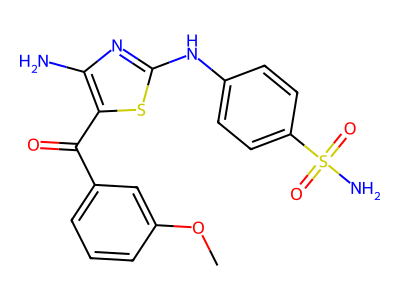

In [4]:
# take the ligand from CDK2 complex 2RAL
mol = Chem.SDMolSupplier('3ral/3ral_ligand.sdf')[0]
AllChem.Compute2DCoords(mol)
mol

### GROW
Let's decorate the molecule with other substituents

In [5]:
mols = list(grow_mol(mol, db_fname, return_mol=True))
len(mols)

63

The function returns the list of smiles and mol objects.

In [6]:
mols[:4]

[['CCOc1cccc(C(=O)c2sc(Nc3ccc(S(N)(=O)=O)cc3)nc2N)c1',
 ['CCCOc1cccc(C(=O)c2sc(Nc3ccc(S(N)(=O)=O)cc3)nc2N)c1',
 ['N#CCOc1cccc(C(=O)c2sc(Nc3ccc(S(N)(=O)=O)cc3)nc2N)c1',
 ['NCCOc1cccc(C(=O)c2sc(Nc3ccc(S(N)(=O)=O)cc3)nc2N)c1',

Keep only Mol objects and remove hydrogens

In [7]:
mols = [Chem.RemoveHs(i[1]) for i in mols]
mols[:4]

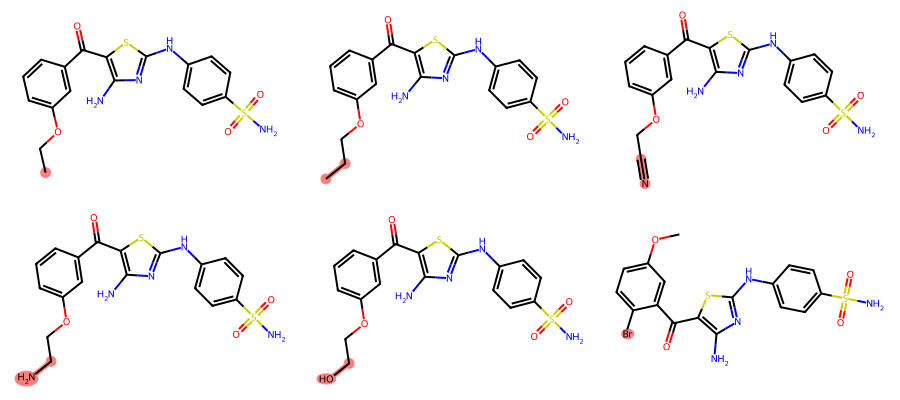

In [8]:
drawgrid(mols[:6])

You may control the size of thje added fragment. By default grow_mol adds fragments with 1-2 heavy atoms.

In [9]:
mols = list(grow_mol(mol, db_fname, return_mol=True, 
                     min_atoms=4, 
                     max_atoms=6))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

412

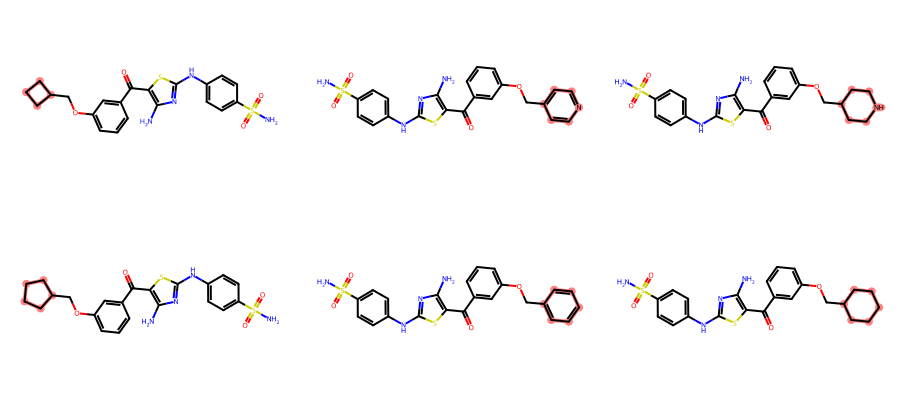

In [10]:
drawgrid(mols[:6])

To make fragment replacement (in the case of GROW this is replacement of a hydrogen) more conservative, one may increase the context radius, By default the radius is 3.

In [11]:
mols = list(grow_mol(mol, db_fname, return_mol=True, 
                     min_atoms=4, 
                     max_atoms=6, 
                     radius=5))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

79

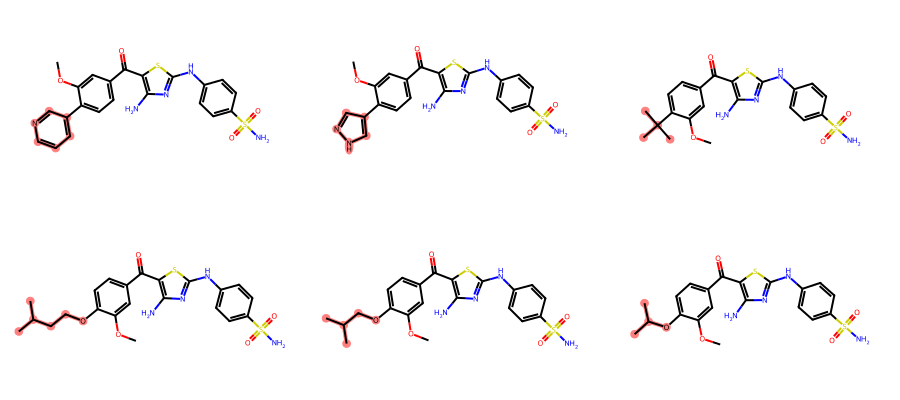

In [12]:
drawgrid(mols[:6])

You may contrtol which atoms to be considered as a growing points.

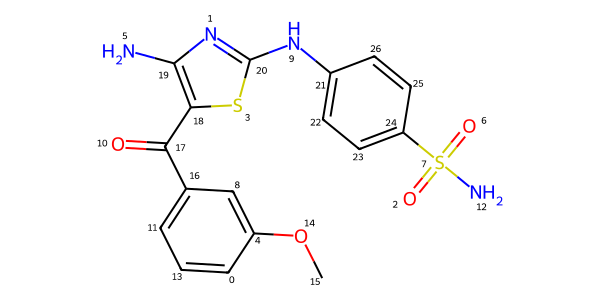

In [13]:
drawer = Draw.rdMolDraw2D.MolDraw2DSVG(600, 300)
opts = drawer.drawOptions()
opts.addAtomIndices = True

# Draw the molecule
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()

# Show
display(SVG(svg))

From 3RAL X-ray structure one may notice that there is some free space near atoms 0, 11 and 13 and it may be tested to be filled with small groups

In [14]:
mols = list(grow_mol(mol, db_fname, return_mol=True, 
                     min_atoms=1, 
                     max_atoms=2, 
                     radius=5, 
                     replace_ids=[0,11,13]))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

7

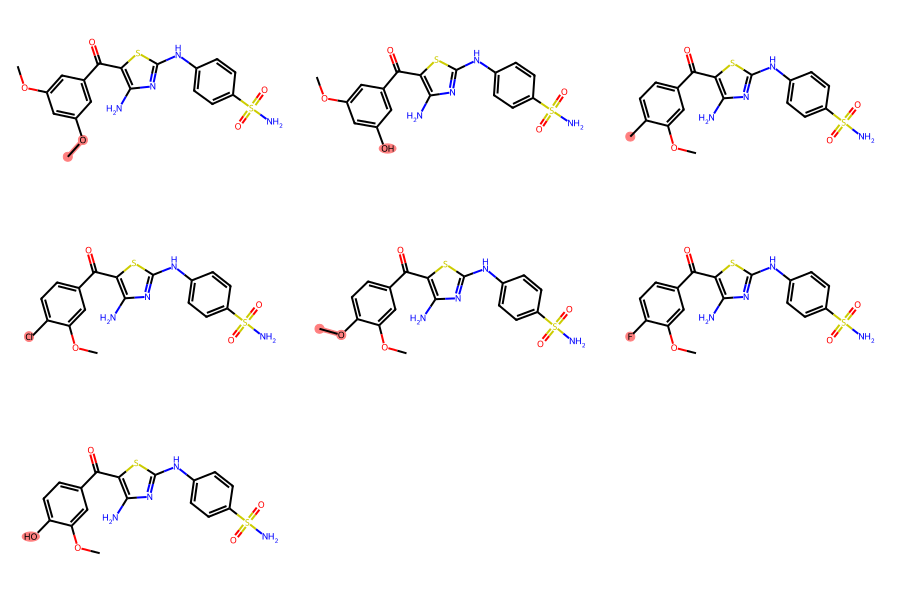

In [15]:
drawgrid(mols)

### MUTATE

By default mutations are unguided and repalce all possible fragments (one at a time) in an input molecule

In [16]:
# default mutations
mols = list(mutate_mol(mol, db_fname, return_mol=True))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

2194

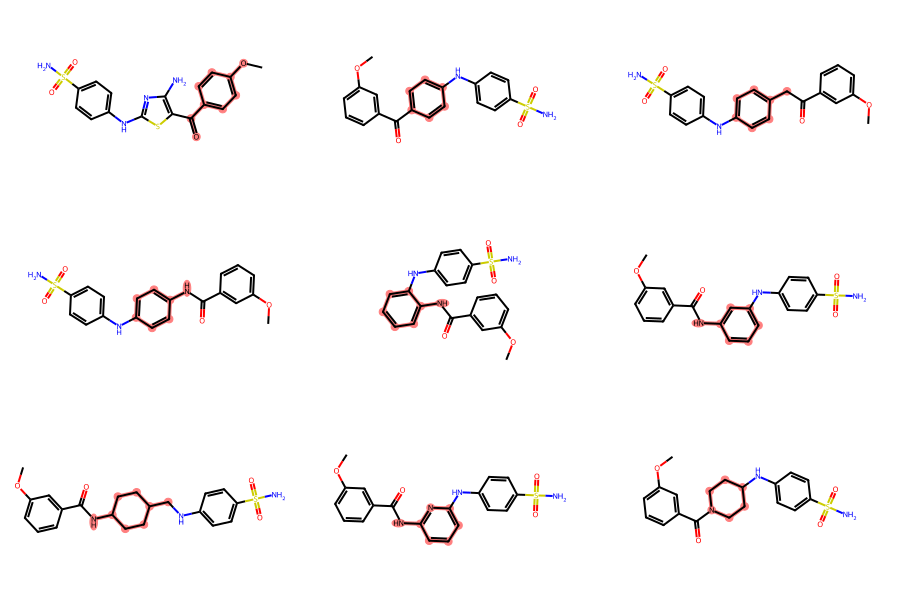

In [17]:
drawgrid(mols[:9])

Let's make more directed modifications. For example, we may want to replace methoxyphenyl to get some anologs, which may be suitable for further docking or FEP analysis.

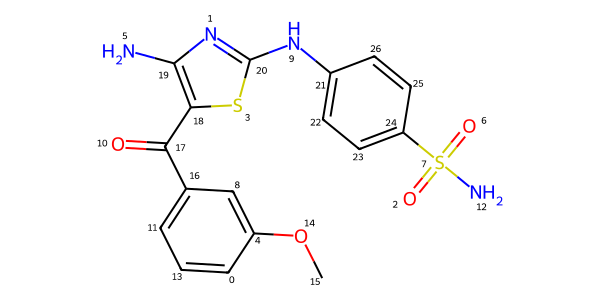

In [18]:
display(SVG(svg))

In [19]:
# ids of atoms in a methoxyphenyl group - 0,4,8,11,13,14,15,16
mols = list(mutate_mol(mol, db_fname, return_mol=True, 
                       replace_ids=[0,4,8,11,13,14,15,16]))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

142

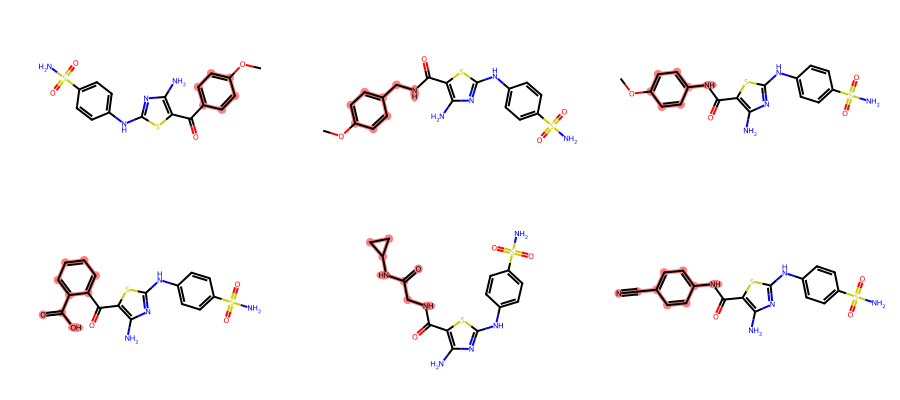

In [20]:
drawgrid([mols[i] for i in (0,1,2,139,138,137)])

If you want to replace a selected fragment as a whole (not getting replacement of only methoxy group), you have to adjust `min_size` and `max_size` to the size of the replaced group

In [21]:
mols = list(mutate_mol(mol, db_fname, return_mol=True, 
                       replace_ids=[0,4,8,11,13,14,15,16], 
                       min_size=8, 
                       max_size=8))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

68

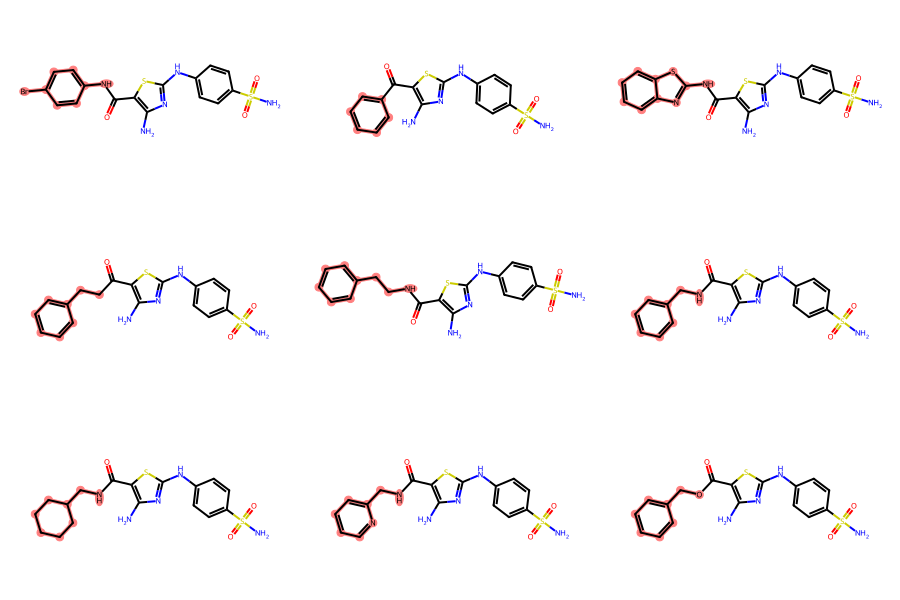

In [22]:
drawgrid(mols[:9])

You can also control the size of replacing fragments. For example, if you want to replace the selected fragment with smaller ones, you have to additionally adjust `min_inc` and `max_inc`. These parameters determine the lower and upped bound of the difference of the size of replacing fragment relatively to the replaced fragment. If the replaced fragment has size 8 and `min_inc=-8` and `max_inc=-3`, the sizes of replacing fragments will be from 0 to 5 heavy atoms (hydrogen can also replace a fragment).

In [23]:
mols = list(mutate_mol(mol, db_fname, return_mol=True, 
                       replace_ids=[0,4,8,11,13,14,15,16], 
                       min_size=8, 
                       max_size=8, 
                       min_inc=-8, 
                       max_inc=-3))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

12

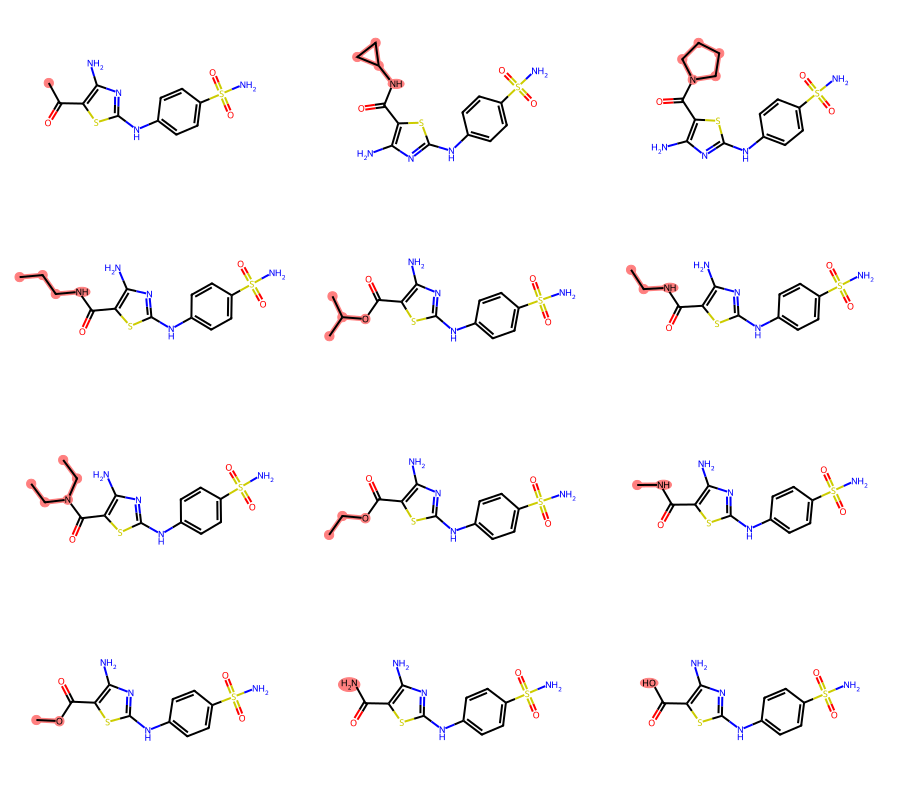

In [24]:
drawgrid(mols)

You may also want to replace the core structure of a ligand (perfoprm scaffold hoppinng).  
Let's replace a whole aminothiazole moiety with other ones.

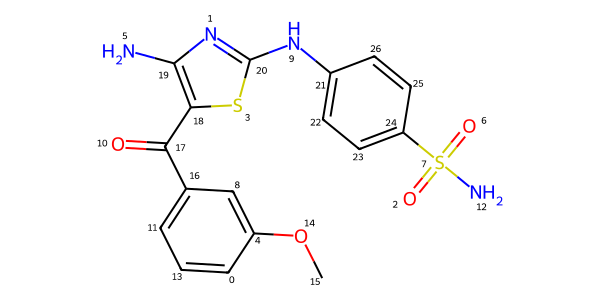

In [25]:
display(SVG(svg))

In [26]:
# ids of aminothiazole - 1,3,5,18,19,20
mols = list(mutate_mol(mol, db_fname, return_mol=True, 
                       replace_ids=[1,3,5,18,19,20], 
                       min_size=6, 
                       max_size=6))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

36

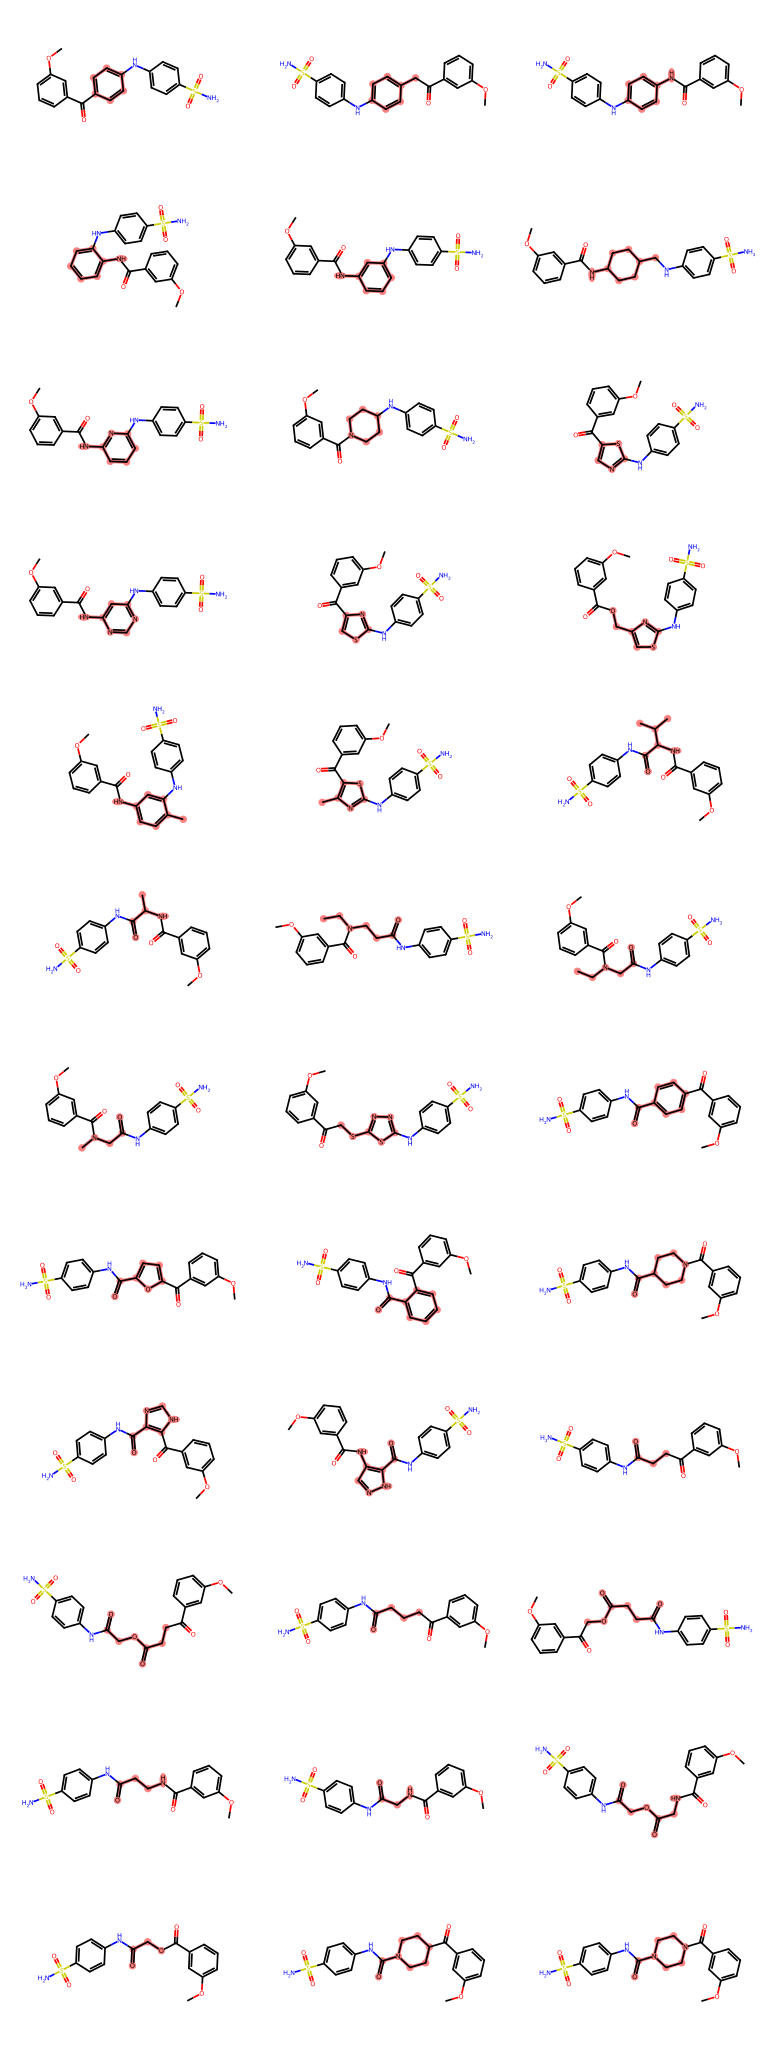

In [27]:
drawgrid(mols)

### LINK

If there are two fragments co-crystallized in different pockjets of the same binding site, one can try to link them to get a single molecule with probably improved affinity.  

Let's assume that we have two fragments of 3RAL ligand remained after removal of aminothiazole.

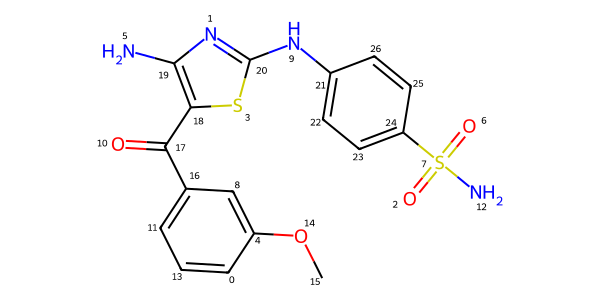

In [28]:
display(SVG(svg))

In [29]:
mol1 = Chem.MolFromSmiles('COc1cc(C=O)ccc1')
mol2 = Chem.MolFromSmiles('c1ccccc1S(=O)(=O)N')
AllChem.Compute2DCoords(mol1)
AllChem.Compute2DCoords(mol2)

0

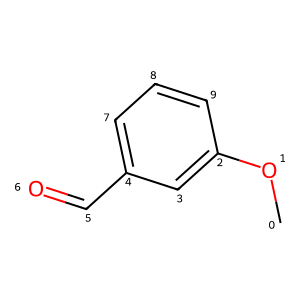

In [30]:
drawer = Draw.rdMolDraw2D.MolDraw2DSVG(300, 300)
opts = drawer.drawOptions()
opts.addAtomIndices = True
drawer.DrawMolecule(mol1)
drawer.FinishDrawing()
svg1 = drawer.GetDrawingText()
display(SVG(svg1))

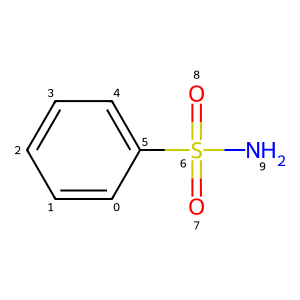

In [31]:
drawer = Draw.rdMolDraw2D.MolDraw2DSVG(300, 300)
opts = drawer.drawOptions()
opts.addAtomIndices = True
drawer.DrawMolecule(mol2)
drawer.FinishDrawing()
svg1 = drawer.GetDrawingText()
display(SVG(svg1))

We want to  
1) connect two fragments by specific atoms
2) keeping the topological distance between fragments the same as in the source ligand
3) linker size from 5 to 8 atoms

In [32]:
# ids of attachment point for mol1 - 5, for mol2 - 2
mols = list(link_mols(mol1, mol2, db_fname, return_mol=True, 
                      replace_ids_1=[5], 
                      replace_ids_2=[2], 
                      dist=4, 
                      min_atoms=5, 
                      max_atoms=8))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

46

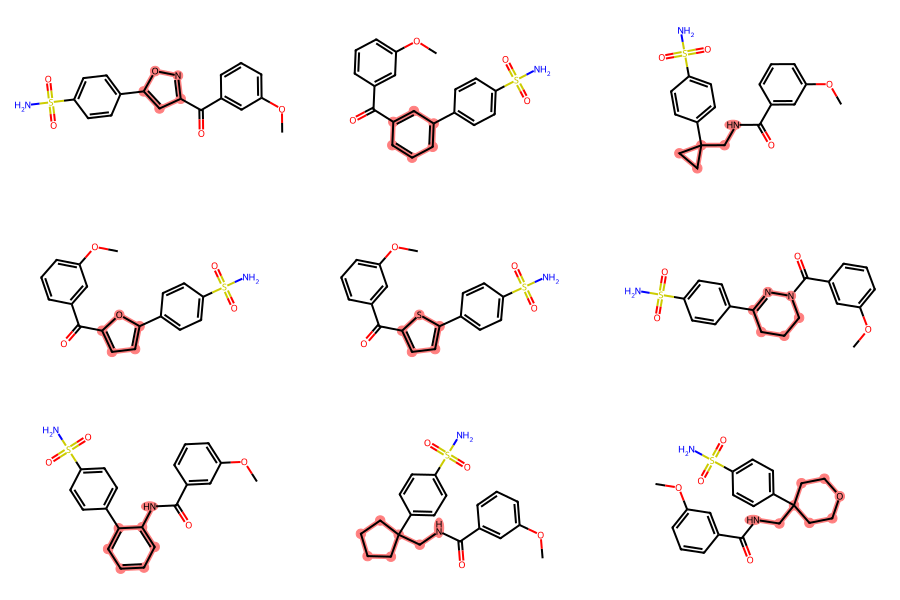

In [33]:
drawgrid(mols[:9])

### Advanced options

#### Filter replacing fragments on the fly

From the repvious example, you may want to get only linkers which do not have any ring. This can be implemented using `filter_func` argument, which takes a custom function performs fragment filtering before generating of output structures.

In [34]:
from crem.crem import _get_replacements

def filter_function(row_ids, cur, radius, atom_number):

    """
    The first three arguments should be always the same as shown in the example. These parameters will be passed to 
    a function from a main function, e.g. from mutate_mol. All other arguments are user-defined. The function should 
    return the list of row ids of fragments which will be used for replacing. 

    :param row_id: a list of row ids from CReM database of those fragments which satisfy other selection criteria
    :param cur: cursor of CReM database
    :param radius: radius of a context 
    :param atom_number: an atomic number, fragments with this atom will be kept
    :return list of remaining row ids
    """

    if not row_ids:
        return []

    # collect fragment SMILES and corresponding row ids from a database
    smis = defaultdict(list)  # {smi_1: [rowid_1, rowid_5, ...], ...}
    for rowid, core_smi, _, _ in _get_replacements(cur, radius, row_ids):
        smis[core_smi].append(rowid)

    output_row_ids = []
    for smi, ids in smis.items():
        for a in Chem.MolFromSmiles(smi).GetAtoms():
            if a.GetAtomicNum() == atom_number:
                output_row_ids.extend(ids)
    return output_row_ids

In [35]:
# ids of attachment point for mol1 - 5, for mol2 - 2
mols = list(link_mols(mol1, mol2, db_fname, return_mol=True, 
                      replace_ids_1=[5], 
                      replace_ids_2=[2], 
                      dist=4, 
                      min_atoms=5, 
                      max_atoms=15, 
                      filter_func=partial(filter_function, atom_number=9)))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

4

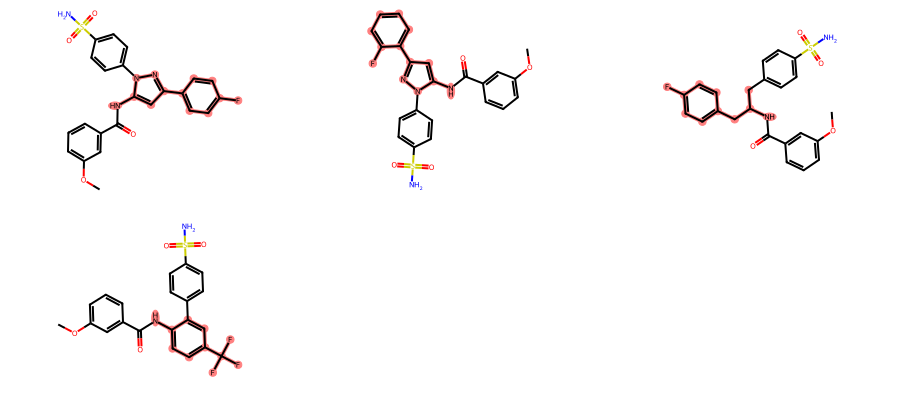

In [36]:
drawgrid(mols)

### Generation of a given number of possible structures

Sometimes there is no need to enumerate all possible derivatives, but only a random subset of possible structures. There is `max_replacements` argument, where you can supply a desired number of output molecules.

In [37]:
# Use the previous example
# ids of attachment point for mol1 - 5, for mol2 - 2
mols = list(link_mols(mol1, mol2, db_fname, return_mol=True, 
                      replace_ids_1=[5], 
                      replace_ids_2=[2], 
                      dist=4, 
                      min_atoms=5, 
                      max_atoms=15, 
                      filter_func=partial(filter_function, atom_number=9), 
                      max_replacements=2))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

2

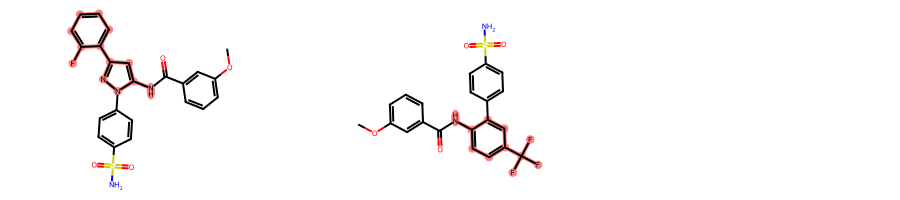

In [38]:
drawgrid(mols)

#### Advanced sampling

Similarly to `filter_func`, there is `sample_func` argument, which takes a custom function performing a random selection. The custom function should always take four input arguments `row_ids, cur, radius, n`.

In [39]:
import numpy as np
from crem.crem import _get_replacements
from rdkit.Chem import rdMolDescriptors

def sample_csp3(row_ids, cur, radius, n):
    """
    Performs random selection of fragments proportionally to a squared fraction of sp3 carbon atoms.
    :param row_ids: the list of row ids of fragments to consider
    :param cur: cursor to the fragment database
    :param radius: context radius
    :param n: the number of fragments to select
    :return: the list of row ids of selected fragments
    """

    # collect fragment SMILES and corresponding row ids from a database
    d = defaultdict(list)  # {smi_1: [rowid_1, rowid_5, ...], ...}
    for rowid, core_smi, _, _ in _get_replacements(cur, radius, row_ids):
        d[core_smi].append(rowid)

    # compute property values, which will be used for selection
    smis = list(d.keys())
    values = [rdMolDescriptors.CalcFractionCSP3(Chem.MolFromSmiles(smi)) ** 2 for smi in smis]
    values = [v + 1e-8 for v in values]
    values = np.array(values) / sum(values)

    # select SMILES and corresponding ids
    selected_smiles = np.random.choice(smis, n, replace=False, p=values).tolist()
    ids = []
    for smi in selected_smiles:
        ids.extend(d[smi])
    ids = random.sample(ids, n)
    return ids

In [40]:
# Use the previous example
# ids of attachment point for mol1 - 5, for mol2 - 2
mols = list(link_mols(mol1, mol2, db_fname, return_mol=True, 
                      replace_ids_1=[5], 
                      replace_ids_2=[2], 
                      dist=4, 
                      min_atoms=5, 
                      max_atoms=15, 
                      filter_func=partial(filter_function, atom_number=9), 
                      sample_func=sample_csp3,
                      max_replacements=1))
mols = [Chem.RemoveHs(i[1]) for i in mols]
len(mols)

1

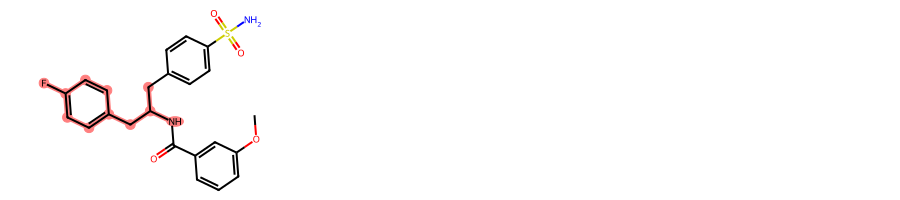

In [41]:
drawgrid(mols)

Some of predefined filtring and sampling functions can be found in `crem.utils`

In [42]:
from crem.utils import sample_csp3
from crem.utils import filter_max_ring_size